In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [3]:
DATA_DIR = '/kaggle/input/jovian-pytorch-z2g/Human protein atlas'



TRAIN_DIR = DATA_DIR + '/train'                           
TEST_DIR = DATA_DIR + '/train'                           

TRAIN_CSV = DATA_DIR + '/train.csv'  
TEST_CSV = DATA_DIR + '/train.csv' 

In [4]:
data_df = pd.read_csv('/kaggle/input/protein/train (1).csv')
data_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


In [5]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [6]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [7]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

In [8]:
# imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
imagenet_stats = ([0.05438065, 0.05291743, 0.07920227], [0.39414383, 0.33547948, 0.38544176])

# train_tfms = T.Compose([
#     T.ToTensor(), 
#     T.Normalize(*imagenet_stats,inplace=True), 
# ])

train_tfms1 = T.Compose([
#     T.RandomCrop(512, padding=8, padding_mode='reflect'),
#     T.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
#     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomRotation(90),
    T.RandomHorizontalFlip(p=0.3),
    T.RandomVerticalFlip(p=0.6),
    T.ToTensor(), 
    T.Normalize(*imagenet_stats,inplace=True), 
    T.RandomErasing(inplace=True)
])

train_tfms2 = T.Compose([
    T.RandomCrop(512, padding=8, padding_mode='reflect'),
#     T.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
#     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomHorizontalFlip(p=0.9),
    T.RandomVerticalFlip(p=0.9),
    T.RandomAffine(degrees=(-45,45)),
    T.ToTensor(), 
    T.Normalize(*imagenet_stats,inplace=True), 
    T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
#     T.Resize(256), 
    T.ToTensor(), 
    T.Normalize(*imagenet_stats)
])

In [9]:
y = data_df['Label'].values
type(y)
print(type(y[1]))

<class 'str'>


In [10]:
# y.shapee
print(type(y))
X = data_df.copy()

<class 'numpy.ndarray'>


In [11]:
np.random.seed(42)
msk = np.random.rand(len(data_df)) < 0.9

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

In [12]:
from torch.utils.data import ChainDataset
# train_ds = HumanProteinDataset(train_df, TRAIN_DIR, transform=train_tfms)
train_ds1 = HumanProteinDataset(train_df, TRAIN_DIR, transform=train_tfms1)
train_ds2 = HumanProteinDataset(train_df, TRAIN_DIR, transform=train_tfms2)
val_ds = HumanProteinDataset(val_df, TRAIN_DIR, transform=valid_tfms)
len(train_ds1), len(val_ds)

(17335, 1901)

In [13]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

In [14]:
batch_size = 80

In [15]:
train_dl1 = DataLoader(train_ds1, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
train_dl2 = DataLoader(train_ds2, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)

In [16]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

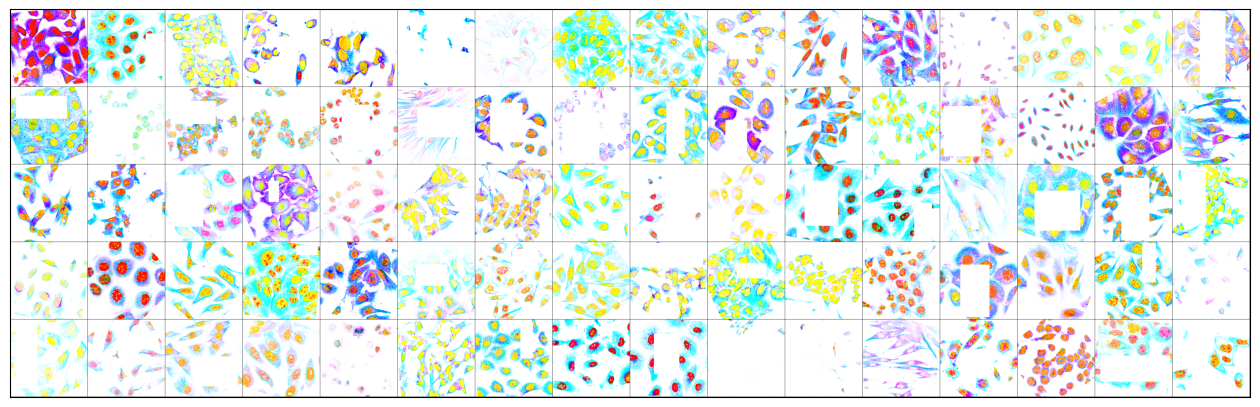

In [17]:
show_batch(train_dl1, invert=True)

In [18]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [19]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [20]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [21]:
from collections import OrderedDict
fc = nn.Sequential(OrderedDict([
('bn1', nn.BatchNorm1d(512)),
('drop1', nn.Dropout(p=0.5)),
('linear1', nn.Linear(512, 256)),
('drop2', nn.Dropout(p=0.5)),
('linear2', nn.Linear(256, 64)),
('drop3', nn.Dropout(p=0.5)),
('linear3', nn.Linear(64, 10))
]))

In [22]:
class ProteinResnet(MultilabelImageClassificationBase):
    def __init__(self, fc):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
#         num_ftrs = self.network.fc.in_features
        self.network.fc = fc
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True


In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
train_dl1 = DeviceDataLoader(train_dl1, device)
train_dl2 = DeviceDataLoader(train_dl2, device)
val_dl = DeviceDataLoader(val_dl, device)

In [26]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, early_stopping,  
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        early_stopping(history[-1]['val_loss'], model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    return history

In [27]:
model = to_device(ProteinResnet(fc), device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 58.1MB/s]


In [28]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.6895451545715332, 'val_score': 0.21002189815044403}]

In [29]:
model.freeze()

In [30]:
# early_stopping = EarlyStopping(patience=5, verbose=True)
epochs = 20
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [31]:
%%time
early_stopping = EarlyStopping(patience=5, verbose=True)
history += fit_one_cycle(epochs, max_lr, model, train_dl1, val_dl, early_stopping,
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.0000, train_loss: 0.7199, val_loss: 0.6709, val_score: 0.3392
Validation loss decreased (inf --> 0.670902).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0000, train_loss: 0.6908, val_loss: 0.6340, val_score: 0.4125
Validation loss decreased (0.670902 --> 0.633990).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0001, train_loss: 0.6556, val_loss: 0.6000, val_score: 0.4975
Validation loss decreased (0.633990 --> 0.599978).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0001, train_loss: 0.5987, val_loss: 0.5083, val_score: 0.6599
Validation loss decreased (0.599978 --> 0.508288).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0001, train_loss: 0.4664, val_loss: 0.2934, val_score: 0.6320
Validation loss decreased (0.508288 --> 0.293397).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.0001, train_loss: 0.3218, val_loss: 0.2436, val_score: 0.6441
Validation loss decreased (0.293397 --> 0.243600).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.0001, train_loss: 0.2844, val_loss: 0.2380, val_score: 0.6457
Validation loss decreased (0.243600 --> 0.238043).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.0001, train_loss: 0.2659, val_loss: 0.2227, val_score: 0.6728
Validation loss decreased (0.238043 --> 0.222704).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.0001, train_loss: 0.2543, val_loss: 0.2105, val_score: 0.6971
Validation loss decreased (0.222704 --> 0.210463).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.0001, train_loss: 0.2449, val_loss: 0.1992, val_score: 0.7056
Validation loss decreased (0.210463 --> 0.199176).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.0001, train_loss: 0.2348, val_loss: 0.2080, val_score: 0.6880
EarlyStopping counter: 1 out of 5


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.0001, train_loss: 0.2302, val_loss: 0.1863, val_score: 0.7339
Validation loss decreased (0.199176 --> 0.186275).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.0001, train_loss: 0.2228, val_loss: 0.1836, val_score: 0.7575
Validation loss decreased (0.186275 --> 0.183580).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.0000, train_loss: 0.2173, val_loss: 0.1785, val_score: 0.7447
Validation loss decreased (0.183580 --> 0.178503).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.0000, train_loss: 0.2095, val_loss: 0.1716, val_score: 0.7635
Validation loss decreased (0.178503 --> 0.171561).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.0000, train_loss: 0.2020, val_loss: 0.1697, val_score: 0.7733
Validation loss decreased (0.171561 --> 0.169723).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.0000, train_loss: 0.1985, val_loss: 0.1683, val_score: 0.7796
Validation loss decreased (0.169723 --> 0.168274).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.0000, train_loss: 0.1945, val_loss: 0.1658, val_score: 0.7815
Validation loss decreased (0.168274 --> 0.165831).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.0000, train_loss: 0.1904, val_loss: 0.1652, val_score: 0.7804
Validation loss decreased (0.165831 --> 0.165195).  Saving model ...


  0%|          | 0/217 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.0000, train_loss: 0.1907, val_loss: 0.1654, val_score: 0.7794
EarlyStopping counter: 1 out of 5
CPU times: user 42min 19s, sys: 33min 32s, total: 1h 15min 51s
Wall time: 1h 12min 17s


In [ ]:
model.summary()

In [32]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

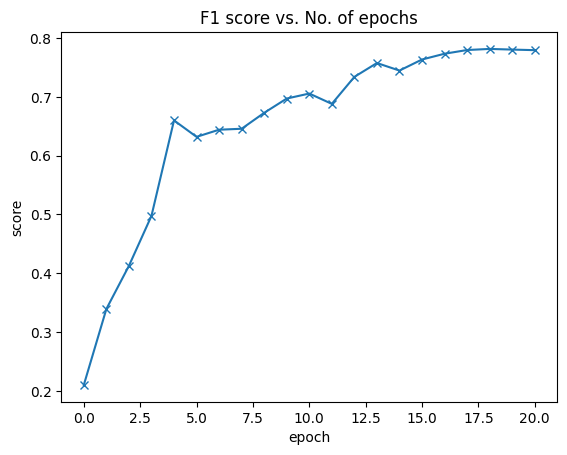

In [33]:
plot_scores(history)

In [34]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

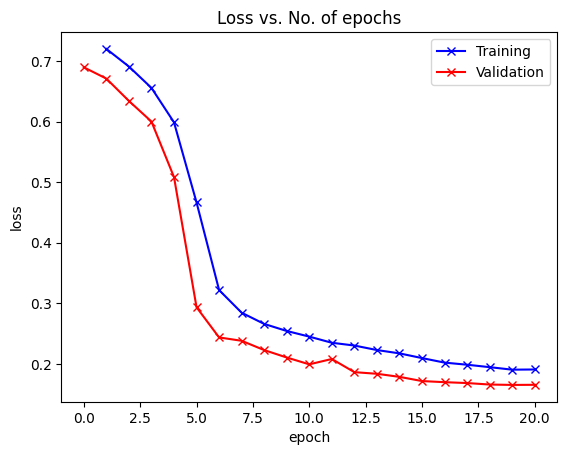

In [35]:
plot_losses(history)

In [36]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [37]:
test_df = pd.read_csv('/kaggle/input/protein/train (1).csv')
TEST_DIR = '/kaggle/input/jovian-pytorch-z2g/Human protein atlas/train'
test_dataset = HumanProteinDataset(test_df, TEST_DIR, transform=valid_tfms)

In [38]:
test_dataset

In [39]:
img, target = test_dataset[0]
img.shape

torch.Size([3, 512, 512])

Prediction:  tensor([0.1275, 0.0554, 0.0789, 0.0575, 0.9196, 0.0177, 0.6336, 0.0315, 0.0449,
        0.0054], device='cuda:0', grad_fn=<SelectBackward0>)
Labels: Nucleoplasm(4) Cytosol(6)


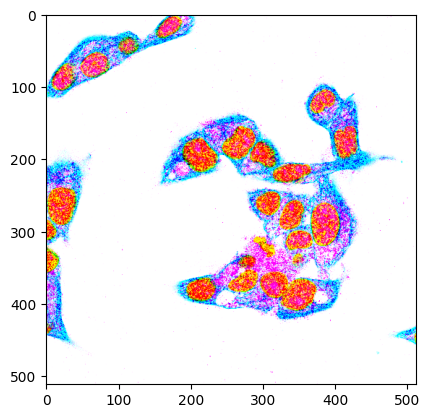

In [40]:
predict_single(test_dataset[1][0])

In [41]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True), device)

In [42]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [43]:
test_preds = predict_dl(test_dl, model)

  0%|          | 0/241 [00:00<?, ?it/s]

In [44]:
submission_df = pd.read_csv(TRAIN_CSV)

In [45]:
submission_df['Pred'] = test_preds

In [46]:
submission_df

,Image,Label,Pred
0,19567,9,9
1,29993,6 4,4 6
2,17186,1 4,4
3,29600,6 2,2 6
4,701,3 4,3 4
...,...,...,...
19231,428,6,6
19232,5342,6 7,7
19233,9806,4,4
19234,16112,5,5


In [47]:
submission_df.to_csv('TransferBasedLearning_Pred.csv', index=False)